# Introduction to Gradient Descent for Neural Networks

First the idea of layers of simple computational units is discussed.  Then the gradient of the error function of the final layer's output with respect to all weights in all layers is defined.  Finally, the gradient function is defined and SGD, Adam and SCG is applied to some simple layered networks.

## Layers of Computational Units

![Two Units](http://www.cs.colostate.edu/~anderson/cs545/notebooks/net1a.png)

$$ 
\begin{align*}
z &= \tanh(v_0 + v_1 x)\\
y &= w_0 + w_1 z
\end{align*}
$$

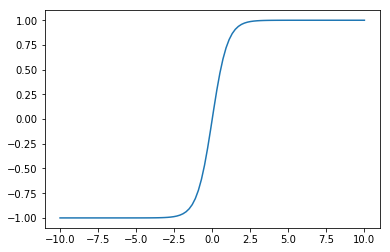

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

xs = np.linspace(-10, 10, 100)
plt.plot(xs, np.tanh(xs))

## Gradient of Error Function with Respect to All Weights

In [5]:
import sympy

In [6]:
x, v, z, w, y, t = sympy.symbols('x v z w y t')
E = (t - y)**2
E

(t - y)**2

In [10]:
z = sympy.tanh(x*v)
y = w*z
E = (t - y)**2
E

(t - w*tanh(v*x))**2

In [8]:
dE = sympy.derive_by_array(E, [v, w])
dE

[-2*w*x*(t - w*tanh(v*x))*(-tanh(v*x)**2 + 1), -2*(t - w*tanh(v*x))*tanh(v*x)]

In [11]:
sympy.simplify(dE)

[2*w*x*(t - w*tanh(v*x))*(tanh(v*x)**2 - 1), -2*(t - w*tanh(v*x))*tanh(v*x)]

![Two Units](http://www.cs.colostate.edu/~anderson/cs545/notebooks/net1a.png)

$$ 
\begin{align*}
z_i &= \tanh(v_0 + v_1 x_i)\\
y_i &= w_0 + w_1 z_i
\end{align*}
$$

$$
\begin{align*}
E &= \frac{1}{N} \sum_{i=1}^N (t_i - y_i)^2\\
\nabla E_{w_0} &= -\frac{2}{N} \sum_{i=1}^N (t_i - y_i)\\
\nabla E_{w_1} &= -\frac{2}{N} \sum_{i=1}^N (t_i - y_i) z_i \\
\nabla E_{v_0} &= -\frac{2}{N} \sum_{i=1}^N (t_i - y_i) w_1 \tanh_i'\\
 &= -\frac{2}{N} \sum_{i=1}^N (t_i - y_i) w_1 (1 - z_i^2)\\
\nabla E_{v_1} &= -\frac{2}{N} \sum_{i=1}^N (t_i - y_i) w_1 \tanh_i' x_i\\
&= -\frac{2}{N} \sum_{i=1}^N (t_i - y_i) w_1 (1-z_i^2) x_i
\end{align*}
$$


Substituting for the common factors:
$$
\begin{align*}
E &= \frac{1}{N} \sum_{i=1}^N (t_i - y_i)^2\\
\nabla E_{w_0} &= -\frac{2}{N} \sum_{i=1}^N (t_i - y_i)\\
&= -\frac{2}{N} \sum_{i=1}^N \delta_i\\
\nabla E_{w_1} &= -\frac{2}{N} \sum_{i=1}^N \delta_i z_i \\
\nabla E_{v_0} &= -\frac{2}{N} \sum_{i=1}^N \delta_i w_1 \tanh_i'\\
 &= -\frac{2}{N} \sum_{i=1}^N \delta_i w_1 (1 - z_i^2)\\
 &= -\frac{2}{N} \sum_{i=1}^N \delta_i^z\\
\nabla E_{v_1} &=  -\frac{2}{N} \sum_{i=1}^N \delta_i^z x_i
\end{align*}
$$



## Python Functions for the Layered Model and its Error Gradient

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas
import optimizers as opt

import IPython.display as ipd  # for display and clear_output
import time  # for sleep

In [13]:
def network_one_layer(w, X, all_outputs=False):
    V = w[0:2].reshape((-1, 1))  # + 1 for the bias weight
    W = w[2:4].reshape((-1, 1))
    Z = np.tanh(V[0] + X @ V[1:])
    Y = W[0] + Z @ W[1:]
    return (Y, Z) if all_outputs else Y

def error_gradient_network_one_layer(w, network, X, T):
    Y, Z = network(w, X, all_outputs=True)
    dEdY = -2 * (T - Y)                        # n_samples x 1
    dYdW = np.insert(Z, 0, 1, axis=1)          # n_samples x 2
    dYdZ = w[3]                                # W[1], last element in w
    dZdV = (1 - Z**2) * np.insert(X, 0, 1, axis=1)  # n_samples x 2
    dEdW = dEdY.T @ dYdW                       # 1 x n_samples @ n_samples x 2 = 1 x 2
    dEdV = dEdY.T @ (dYdZ * dZdV)              # 1 x n_samples @ (1 * n_samples x 2) = 1 x 2    
    dEdw = np.hstack((dEdV, dEdW)) / X.shape[0]  # 1 x 4

    return dEdw.reshape((-1, 1))               # 4 x 1

def mse(w, model, X, T):
    Y = model(w, X)
    return np.mean((T - Y)**2)

In [14]:
data = pandas.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',', usecols=range(15), na_values=-200)
data = data[['Time', 'CO(GT)']]
data = data [:23*4]
data = data.dropna(axis=0)
data.shape

(87, 2)

In [15]:
hour = [int(t[:2]) for t in data['Time']]
X = np.array(hour).reshape(-1, 1)
CO = data['CO(GT)']
T = np.array(CO).reshape(-1, 1)
np.hstack((X, T))[:10]  # show the first 10 samples of hour, CO

array([[18. ,  2.6],
       [19. ,  2. ],
       [20. ,  2.2],
       [21. ,  2.2],
       [22. ,  1.6],
       [23. ,  1.2],
       [ 0. ,  1.2],
       [ 1. ,  1. ],
       [ 2. ,  0.9],
       [ 3. ,  0.6]])

In [16]:
n_inputs = X.shape[1]
n_units = 1
n_V = n_units * (n_inputs + 1)
n_W = n_units + 1

initial_w = np.zeros((n_V + n_W, 1))
initial_w = np.random.uniform(-0.1, 0.1, (n_V + n_W, 1))

result_sgd = opt.sgd(initial_w,
                     mse, error_gradient_network_one_layer, fargs=[network_one_layer, X, T],
                     n_iterations=2000, learning_rate=1e-4, momentum_rate=0.5)
result_adam = opt.adam(initial_w, 
                       mse, error_gradient_network_one_layer, fargs=[network_one_layer, X, T],
                        n_iterations=2000, learning_rate=1e-3)
result_scg = opt.scg(initial_w,
                     mse, error_gradient_network_one_layer, fargs=[network_one_layer, X, T],
                     n_iterations=2000)

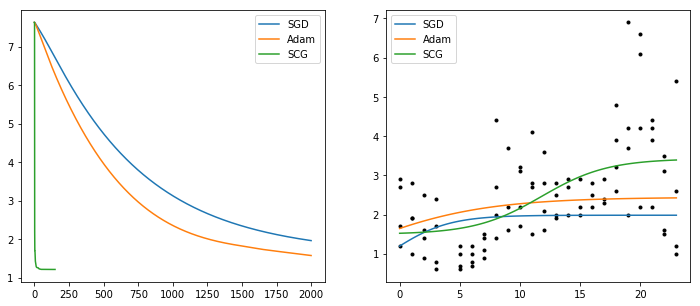

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(result_sgd['ftrace'], label='SGD')
plt.plot(result_adam['ftrace'], label='Adam')
plt.plot(result_scg['ftrace'], label='SCG')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X, T, 'k.')
xs = np.linspace(0, 23, 100).reshape((-1, 1))
plt.plot(xs, network_one_layer(result_sgd['w'], xs), label='SGD')
plt.plot(xs, network_one_layer(result_adam['w'], xs), label='Adam')
plt.plot(xs, network_one_layer(result_scg['w'], xs), label='SCG')
plt.legend();

Now, what is the gradient of our mean squared error with respect to all weights if our model has two units in the first layer?  How does the gradient of mean squared error with respect to all weights change with more than one variable input possible in each unit?

![Three Units](http://www.cs.colostate.edu/~anderson/cs545/notebooks/net-2unitsa.png)

Helpful resources:

* [Backpropagation tutorial by Google](https://google-developers.appspot.com/machine-learning/crash-course/backprop-scroll/)
* [What is backpropagation really doing? | Deep learning, chapter 3](https://www.youtube.com/watch?v=Ilg3gGewQ5U)